In [1]:
# Execute the following to get the neural_network module

# Clone the repository
# ! git clone https://github.com/mkpro118/CS-539-project.git

# Append to path to use in import statements
# import sys
# sys.path.insert(0, 'CS-539-project')

In [2]:
# The backbone library of this entire Project
import numpy as np

# We have a utility function to load the images
# For more info see load_data's docstrings in data/__init__.py 
from data import load_data

data = load_data()

X, y = data.data, data.labels  # The data
labels, names =  data.unique_labels, data.unique_label_names
input_shape = data.shape

print(f'X.shape      = {X.shape}')
print(f'y.shape      = {y.shape}')
print(f'labels.shape = {labels.shape}')
print(f'Label names  = {", ".join(names)}')

X.shape      = (651, 3, 224, 224)
y.shape      = (651,)
labels.shape = (5,)
Label names  = bishop, knight, pawn, queen, rook


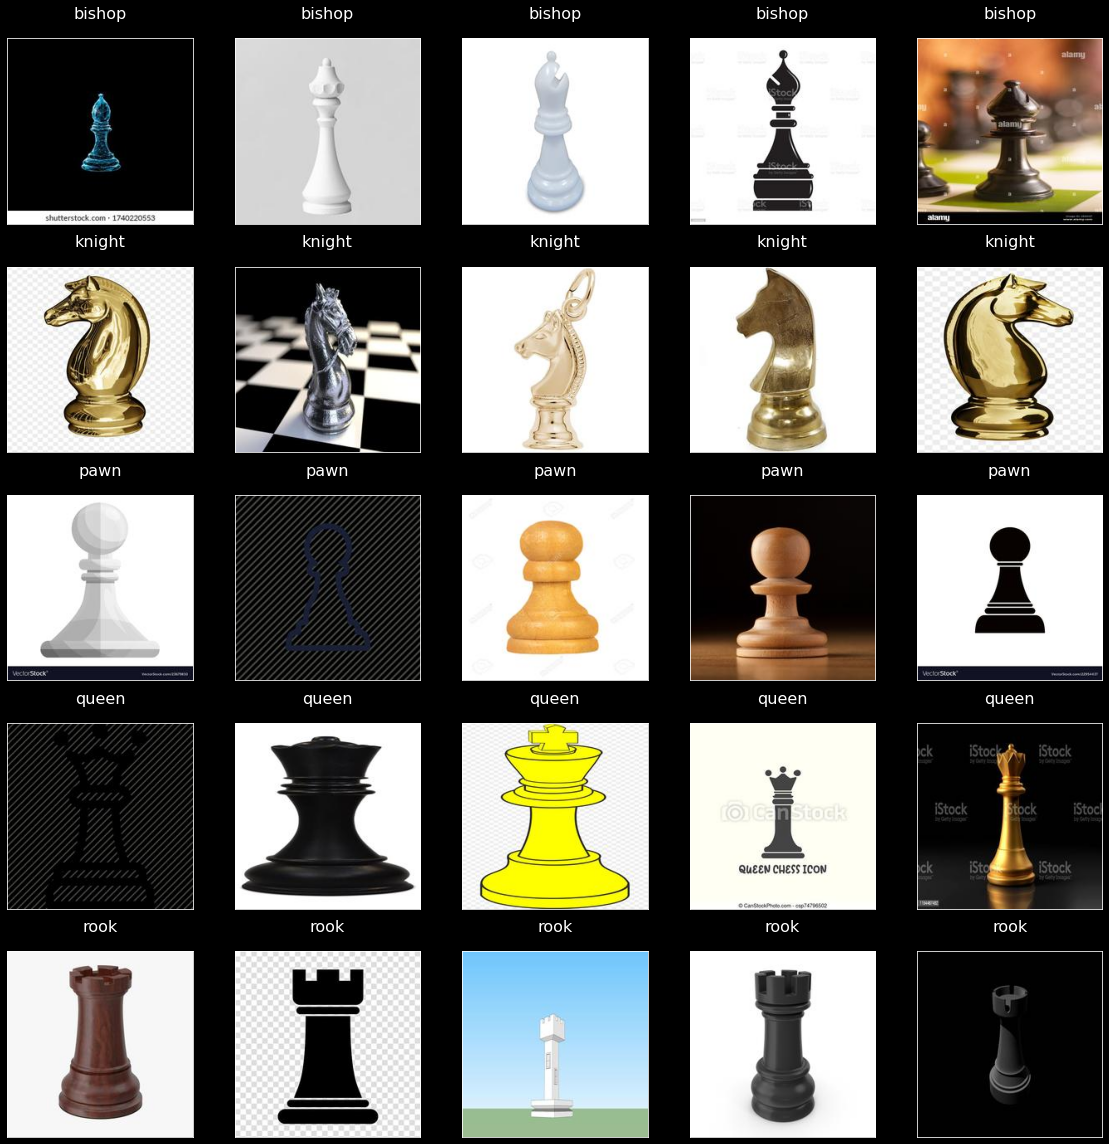

In [3]:
# Visualize the data

# Samples n data points across all labels
def sample(X, y, samples):
    unique_ys = np.unique(y, axis=0)
    result = []
    for unique_y in unique_ys:
        val_indices = np.argwhere(y==unique_y).flatten()
        random_samples = np.random.choice(val_indices, samples, replace=False)
        result.extend(map(lambda x:(x, unique_y), X[random_samples]))
    return result
    

_X = sample(X, y, 5) # get 5 samples from each label

# Another S tier library
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('dark_background')
plt.rcParams['legend.fontsize'] = 16  # BIGGER FONTS
plt.rcParams['axes.titlepad'] = 20    # space between titles and plots

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(16, 16))
axs = axs.flatten()

for i, (ax, (a, b)) in enumerate(zip(axs, _X)):
    # we load data channels first, imshow requires channels last
    ax.imshow(a.transpose(1, 2, 0))
    
    # Fancy logic to get the label names
    ax.set_title(f'{names[i // 5]}', fontsize=16)
    
    # Plotting images, don't need ticks
    ax.tick_params(
        left=False,
        labelleft=False,
        labelbottom=False,
        bottom=False
    )

plt.tight_layout()
plt.show()

In [4]:
# We needed int values to visualize on matplotlib, for the experiment we need floats
X = X.astype('float32')

In [5]:
# Partition into training and testing (holdout) data
# Note: train_test_split stratifies the data by default


from neural_network.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Sanity Check
print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (453, 3, 224, 224)
y_train.shape = (453,)
X_test.shape  = (198, 3, 224, 224)
y_test.shape  = (198,)


In [6]:
# Partition into training and testing (validation) data
from neural_network.model_selection import StratifiedKFold

# 3 fold cross validation wasn't yielding a good performance
# We're using 5 fold CV to allow larger proportion of the training data
# to be used for training
n_splits = 5
skf = StratifiedKFold(n_splits=5)

cv_splitter = skf.split(X_train, y_train)  # stratified KFold spliterator

In [7]:
# One hot encode the labels

from neural_network.preprocess import OneHotEncoder

encoder = OneHotEncoder().fit(labels)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Sanity check
print(f'y_train.shape = {y_train.shape}')
print(f'y_test.shape  = {y_test.shape}')

y_train.shape = (453, 5)
y_test.shape  = (198, 5)


In [8]:
# Standardize the inputs

from neural_network.preprocess import Standardizer

# Fit with X_train to avoid leakage of data from testing (holdout) set
standardizer = Standardizer().fit(X_train)  

X_train = standardizer.transform(X_train)
X_test = standardizer.transform(X_test)

# Sanity check
print(f'X_train.min() = {X_train.min()}')
print(f'X_train.max() = {X_train.max()}')
print(f'X_test.min() = {X_test.min()}')
print(f'X_test.max() = {X_test.max()}')

X_train.min() = -2.3049509525299072
X_train.max() = 1.598844051361084
X_test.min() = -2.142951250076294
X_test.max() = 1.598844051361084


In [9]:
# Scale the inputs in the range -1 to 1

from neural_network.preprocess import Scaler

# Again, fit with X_train to avoid leakage of data from testing (holdout) set
scaler = Scaler(-1, 1).fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Sanity check
print(f'X_train.min() = {X_train.min()}')
print(f'X_train.max() = {X_train.max()}')
print(f'X_test.min() = {X_test.min()}')
print(f'X_test.max() = {X_test.max()}')

X_train.min() = -1.0
X_train.max() = 1.0
X_test.min() = -1.0
X_test.max() = 1.0


In [10]:
# We're done with data preprocessing,
# here comes the fun part

# We designed 4 layers, 
# Dense
# Convolutional (2D, w/o stride or padding support)
# BatchNormalization (this was particularly helpful in providing numerical stability)
# Flatten

from neural_network.model import Sequential
from neural_network.layers import BatchNormalization, Convolutional, Dense, Flatten

def get_model():
    # Define a sequential model
    model = Sequential()

    # Add layers to the model
    # Experiments show a Deep neural network is required
    # Experiments with lesser 35 than layers failed spectacularly
    # Activation functions, Number of filters, 
    # and FC layer nodes were chosen at random
    # Number of filters were randomly chosen to be perfect squares
    # Number of FC layer nodes were chosen to be powers of 2 (except the last layer)
    model.add(
        Convolutional(25, 3, input_shape=input_shape, activation='leaky_relu'),
        Convolutional(16, 3, activation='tanh'),
        Convolutional(9, 3, activation='relu'),
        BatchNormalization(),
        Convolutional(16, 3, activation='tanh'),
        Convolutional(9, 3, activation='tanh'),
        Convolutional(25, 3, activation='relu'),
        BatchNormalization(),
        Convolutional(16, 3, activation='tanh'),
        Convolutional(9, 3, activation='leaky_relu'),
        BatchNormalization(),
        Convolutional(4, 3, activation='tanh'),
        Convolutional(2, 3, activation='relu'),
        BatchNormalization(),
        Convolutional(2, 3, activation='tanh'),
        Convolutional(1, 3, activation='tanh'),
        Flatten(),
        Dense(4096, activation='tanh'),
        Dense(4096, activation='tanh'),
        Dense(2048, activation='leaky_relu'),
        BatchNormalization(),
        Dense(2048, activation='relu'),
        Dense(1024, activation='tanh'),
        Dense(1024, activation='tanh'),
        Dense(1024, activation='sigmoid'),
        Dense(512, activation='sigmoid'),
        Dense(512, activation='sigmoid'),
        Dense(512, activation='tanh'),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dense(256, activation='leaky_relu'),
        BatchNormalization(),
        Dense(256, activation='tanh'),
        Dense(256, activation='tanh'),
        Dense(128, activation='sigmoid'),
        Dense(64, activation='sigmoid'),
        Dense(32, activation='leaky_relu'),
        BatchNormalization(),
        Dense(16, activation='tanh'),
        Dense(16, activation='tanh'),
        Dense(5, activation='softmax')
    )
    
    # Compile and build  the model
    model.compile(cost='crossentropy', metrics=['accuracy_score'])
    
    return model

# Displaying model structure
get_model().summary()

Sequential Model: 'Sequential Model' with 42 layers
Input Shape: (3, 224, 224)
------------------------------------------------------------------------------------------
|  # |       Layer        |                             Info                             |
------------------------------------------------------------------------------------------
|  1 |   Convolutional    | Convolutional Layer with 25 filters, 3 channels, 3x3 kernel  |
|  2 |   Convolutional    | Convolutional Layer with 16 filters, 25 channels, 3x3 kernel |
|  3 |   Convolutional    | Convolutional Layer with 9 filters, 16 channels, 3x3 kernel  |
|  4 | BatchNormalization |                  Batch Normalization Layer                   |
|  5 |   Convolutional    | Convolutional Layer with 16 filters, 9 channels, 3x3 kernel  |
|  6 |   Convolutional    | Convolutional Layer with 9 filters, 16 channels, 3x3 kernel  |
|  7 |   Convolutional    | Convolutional Layer with 25 filters, 9 channels, 3x3 kernel  |
|  8 | Batc

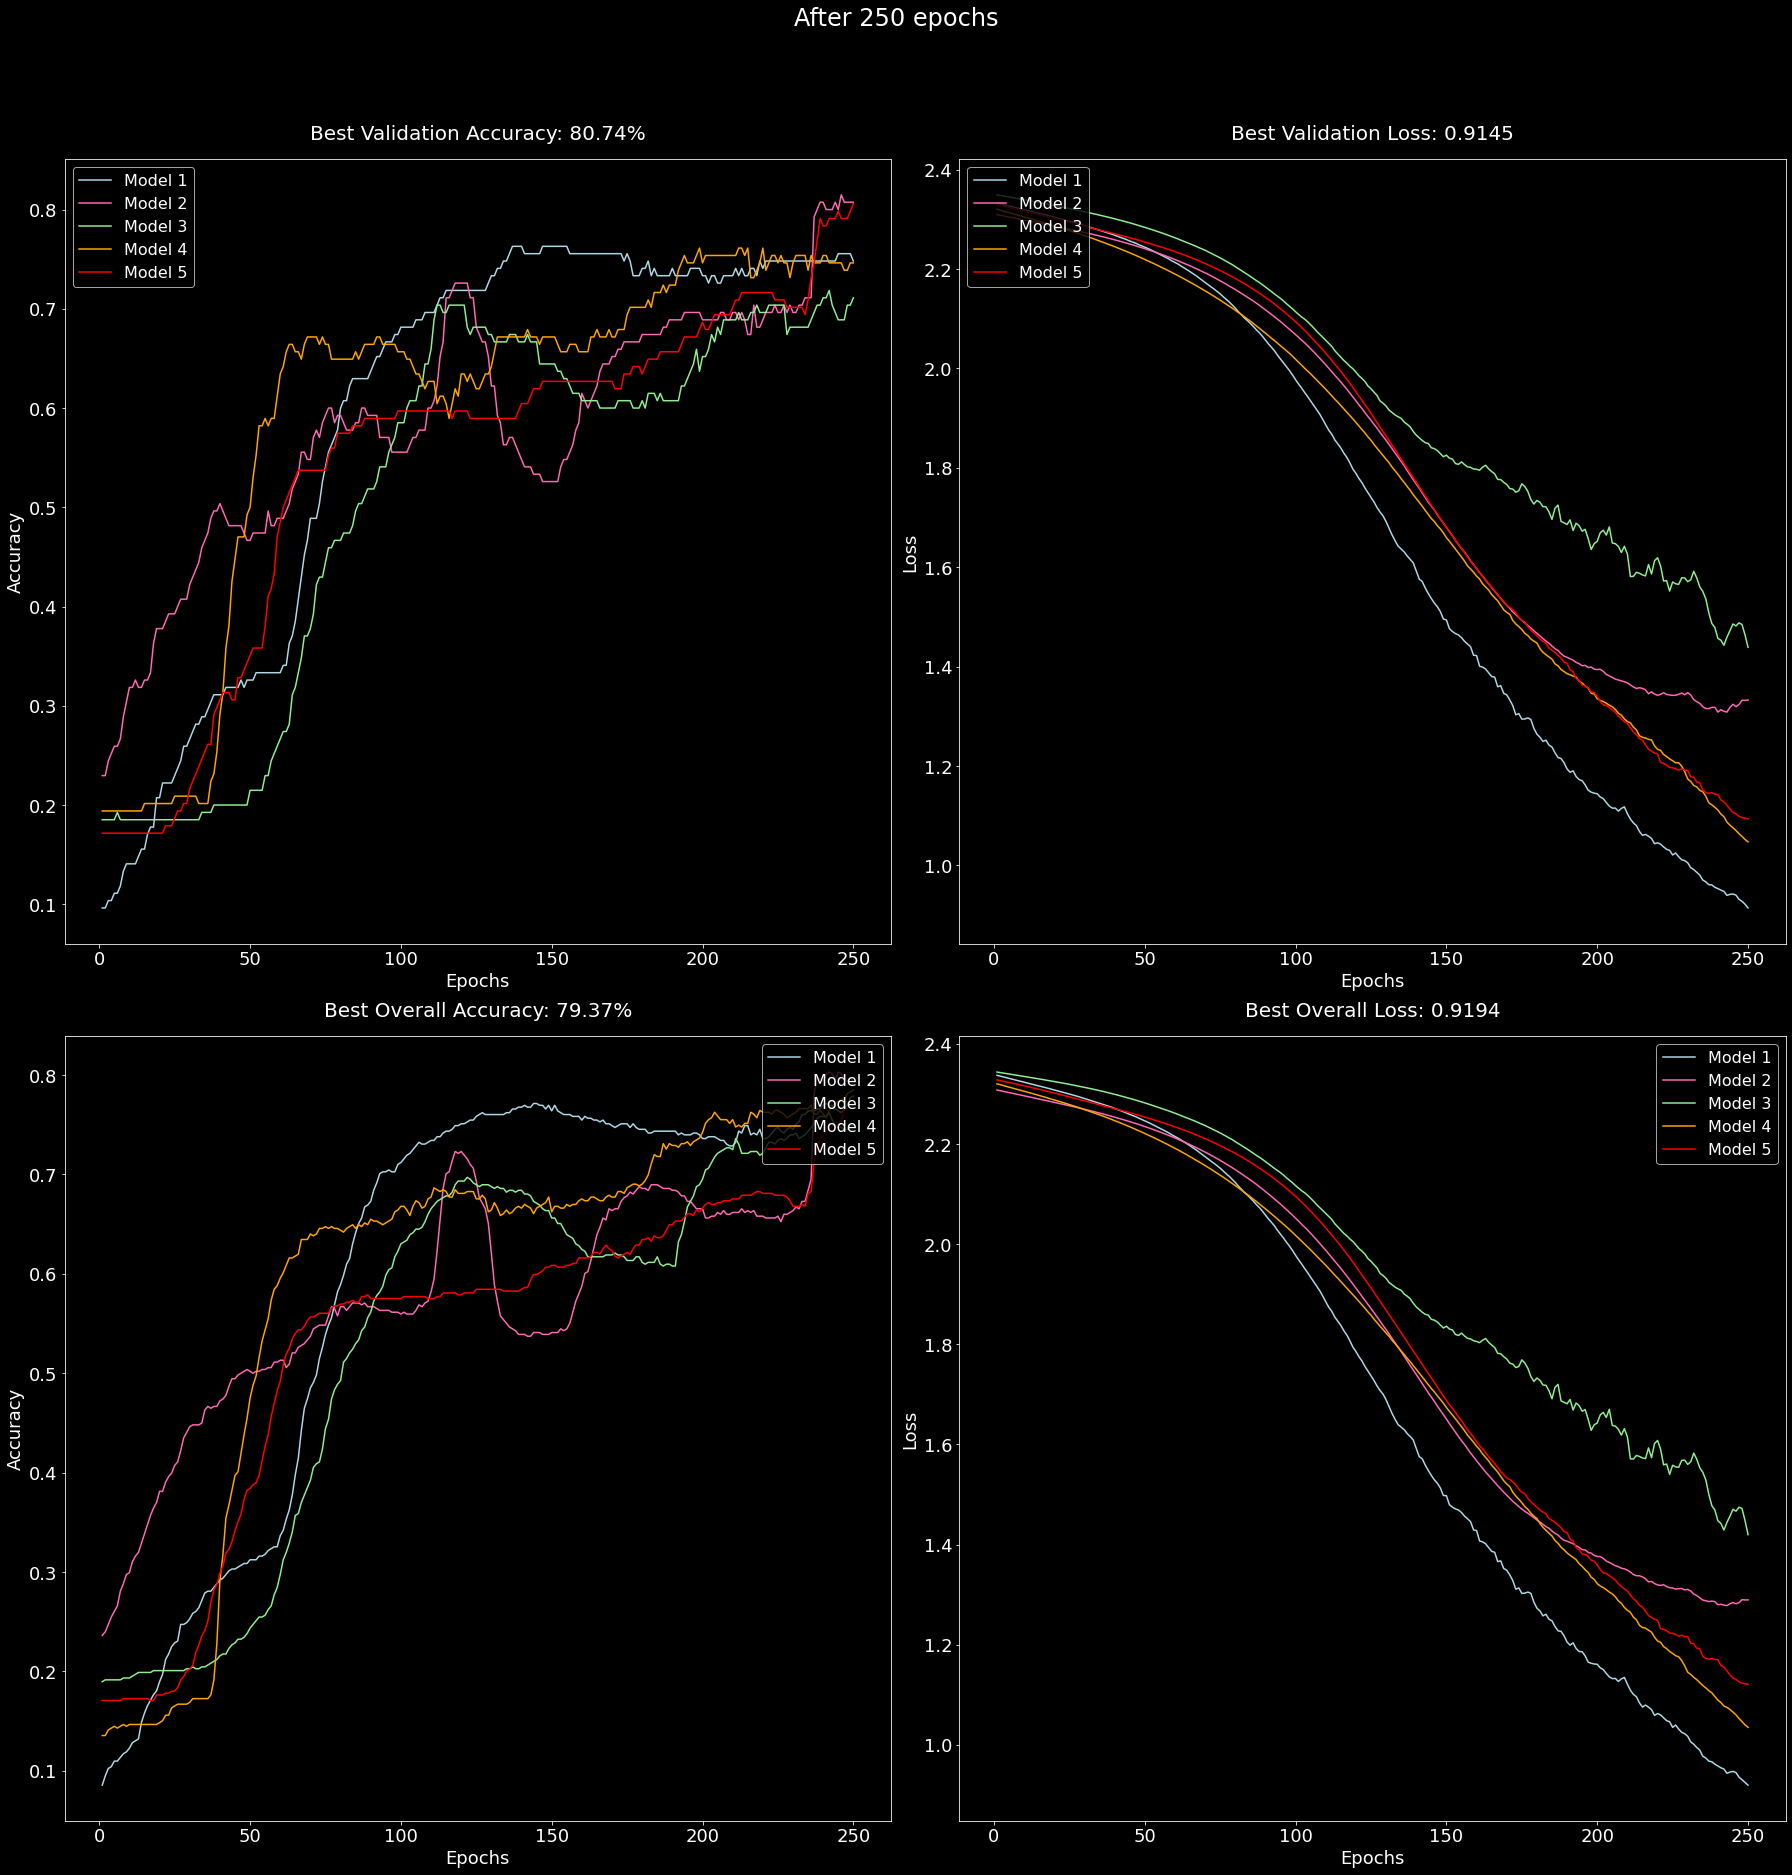

In [11]:
# Train the model with Cross Validation

from collections import defaultdict as defdict  # Store history for live plots
from itertools import count                     # replacement for enumerate
from math import inf as infinity                # initial accuracy and loss

# To plot real time accuracy and loss 
from IPython.display import display, clear_output 
clear_output(wait=False)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))

ax1.set_title('Validation Accuracy')
ax2.set_title('Validation Loss')
ax3.set_title('Overall Accuracy')
ax4.set_title('Overall Loss')

for ax in (ax1, ax3):
    ax.set_ylabel('Accuracy')
for ax in (ax2, ax4):
    ax.set_ylabel('Loss')
for ax in (ax1, ax3, ax3, ax4):
    ax.set_xlabel('Epochs')

# plot updates after that many epochs
update_frequency = 10

# Warning, the following 

# Define models
models = [get_model() for _ in range(n_splits)]

# Trainers on the KFold split data
# Trainers are generators that run exactly 1 epoch of training
# After every call to __next__ [next(trainer)],
# trainers yield a dictionary with the following information
# overall accuracy, overall loss, validation accuracy, validation loss
# We use these to plot a real time chart of the model's training
# Note that we use trainers instead of directly training
# to obtain inference over every epoch
trainers = [
    models[i].fit(
        X_train[train],
        y_train[train],
        epochs=250,
        steps_per_epoch=8,
        validation_data=(X_train[validate], y_train[validate]),
        verbose=False,    # The output is huge otherwise
        get_trainer=True, # Get trainer (a generator) instead of training
    ) for i, (train, validate) in enumerate(cv_splitter)]

history = {
    num: {
        'overall': defdict(list),
        'validation': defdict(list),
    } for num in range(len(models))
}

history.update({
    'best': {
        'overall': {
            'accuracy': -infinity,
            'loss': infinity,
        },
        'validation': {
            'accuracy': -infinity,
            'loss': infinity,
        },
    },
})

colors = ['lightblue', 'hotpink', 'lightgreen', 'orange', 'red']

for epoch in count(start=1):
    try:
        # Warning, the following code might be a BrainF##k
        data = tuple(map(next, trainers))
        [
            history[num][type_][metric].append(data[num][type_][metric])
            for num in range(len(models))
            for type_ in data[num].keys()
            for metric in data[num][type_].keys()
        ]
    except (StopIteration, IndexError):  # Generators stop as training completes
        break
    
    # Lazy updates to speed up training
    if epoch % update_frequency != 0:
        continue

    # Update with epcoh count
    fig.suptitle(f'After {epoch} epochs', fontsize=24, y=1.04)

    # Clear all axes to plot anew
    for ax in (ax1, ax2, ax3, ax4):
        ax.cla()

    # Live Plots
    for num in range(len(models)):
        # The considering the brainf##k above, this should be self explanatory
        ax1.plot(
            np.arange(len(history[num]['validation']['accuracy'])) + 1,
            history[num]['validation']['accuracy'],
            color=colors[num],
            label=f'Model {num + 1}'
        )
        ax2.plot(
            np.arange(len(history[num]['validation']['loss'])) + 1,
            history[num]['validation']['loss'],
            color=colors[num],
            label=f'Model {num + 1}'
        )
        ax3.plot(
            np.arange(len(history[num]['overall']['accuracy'])) + 1,
            history[num]['overall']['accuracy'],
            color=colors[num],
            label=f'Model {num + 1}'
        )
        ax4.plot(
            np.arange(len(history[num]['overall']['loss'])) + 1,
            history[num]['overall']['loss'],
            color=colors[num],
            label=f'Model {num + 1}'
        )
        
    # Update the titles with best accuracy and loss information
    x = max(history[num]["validation"]["accuracy"][-1] for num in range(len(models)))
    x = max(history['best']['validation']['accuracy'], x)
    history['best']['validation']['accuracy'] = x
    ax1.set_title(f'Best Validation Accuracy: {np.around(x * 100, 2)}%', fontsize=20, pad=20)
    ax1.legend(loc='upper left')
    
    x = min(history[num]["validation"]["loss"][-1] for num in range(len(models)))
    x = min(history['best']['validation']['loss'], x)
    history['best']['validation']['loss'] = x
    ax2.set_title(f'Best Validation Loss: {np.around(x, 4)}', fontsize=20, pad=20)
    ax2.legend(loc='upper left')
    
    x = max(history[num]["overall"]["accuracy"][-1] for num in range(len(models)))
    x = max(history['best']['overall']['accuracy'], x)
    history['best']['overall']['accuracy'] = x
    ax3.set_title(f'Best Overall Accuracy: {np.around(x * 100, 2)}%', fontsize=20, pad=20)
    ax3.legend(loc='upper right')
    
    x = min(history[num]["overall"]["loss"][-1] for num in range(len(models)))
    x = min(history['best']['overall']['loss'], x)
    history['best']['overall']['loss'] = x
    ax4.set_title(f'Best Overall Loss: {np.around(x, 4)}', fontsize=20, pad=20)    
    ax4.legend(loc='upper right')
    
    for ax in (ax2, ax4):
        ax.set_xlabel('Epochs', fontsize=18)
        ax.set_ylabel('Loss', fontsize=18)

    for ax in (ax1, ax3):
        ax.set_xlabel('Epochs', fontsize=18)
        ax.set_ylabel('Accuracy', fontsize=18)
        
    for ax in (ax1, ax2, ax3, ax4):
        ax.tick_params(axis='both', labelsize=18)
    
    fig.tight_layout()
        
    clear_output(wait=False)
    display(fig)
    plt.pause(0.1)

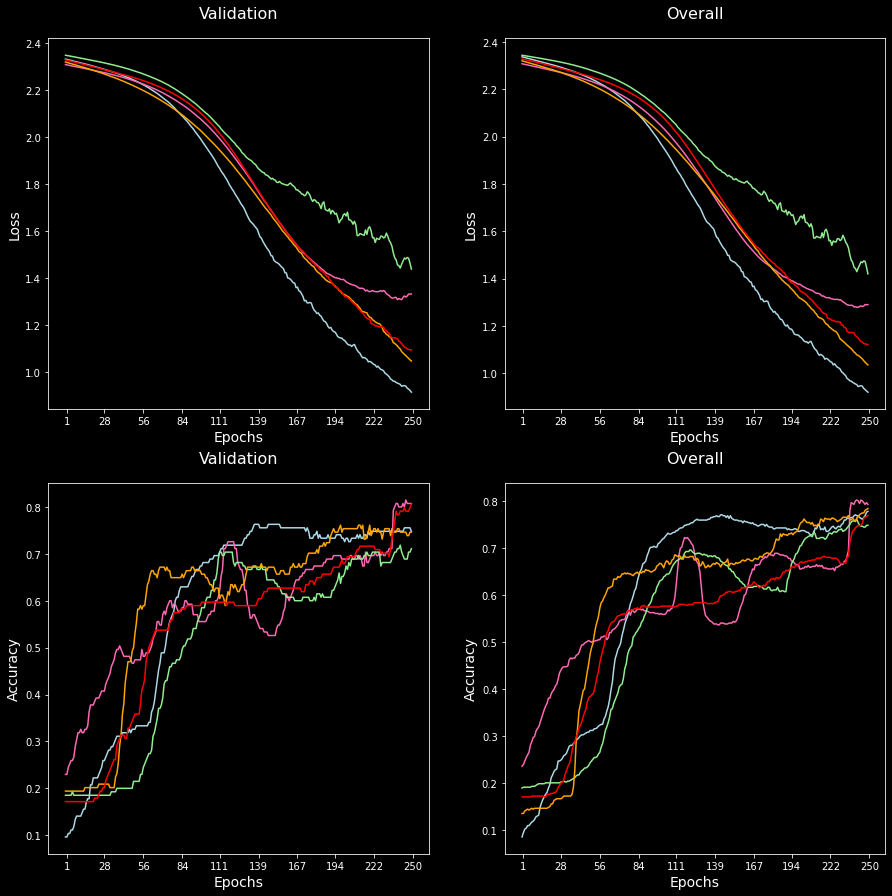

In [12]:
# Plot model's learning via accuracy and loss, 
# The one above was covered by the legends 
# (sorry about that, but this was easier than retraining for 13 hours)

validation_history = [model.history['validation'] for model in models]
model_history = [model.history['overall'] for model in models]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

for num in range(len(models)):
    ax1.plot(
        np.arange(len(validation_history[num]['loss'])),
        validation_history[num]['loss'],
        color=colors[num],
        label=f'Model {num + 1}'
    )
    ax2.plot(
        np.arange(len(model_history[num]['loss'])),
        model_history[num]['loss'],
        color=colors[num],
        label=f'Model {num + 1}'
    )
    ax3.plot(
        np.arange(len(validation_history[num]['accuracy_score'])),
        validation_history[num]['accuracy_score'],
        color=colors[num],
        label=f'Model {num + 1}'
    )
    ax4.plot(
        np.arange(len(model_history[num]['accuracy_score'])),
        model_history[num]['accuracy_score'],
        color=colors[num],
        label=f'Model {num + 1}'
    )

for ax in (ax1, ax2):
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

for ax in (ax3, ax4):
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)


for ax in (ax1, ax2, ax3, ax4):
    ax.set_xticks(np.linspace(1, len(model_history[0]['loss']), 10, dtype=int))
    ax.set_xticklabels(map(str, np.linspace(1, len(model_history[0]['loss']), 10, dtype=int)))

ax1.set_title('Validation', fontsize=16)
ax2.set_title('Overall', fontsize=16)
ax3.set_title('Validation', fontsize=16)
ax4.set_title('Overall', fontsize=16)

plt.show()

In [13]:
# Make predictions on the testing data
predictions = [model.predict(X_test, classify=True) for model in models]

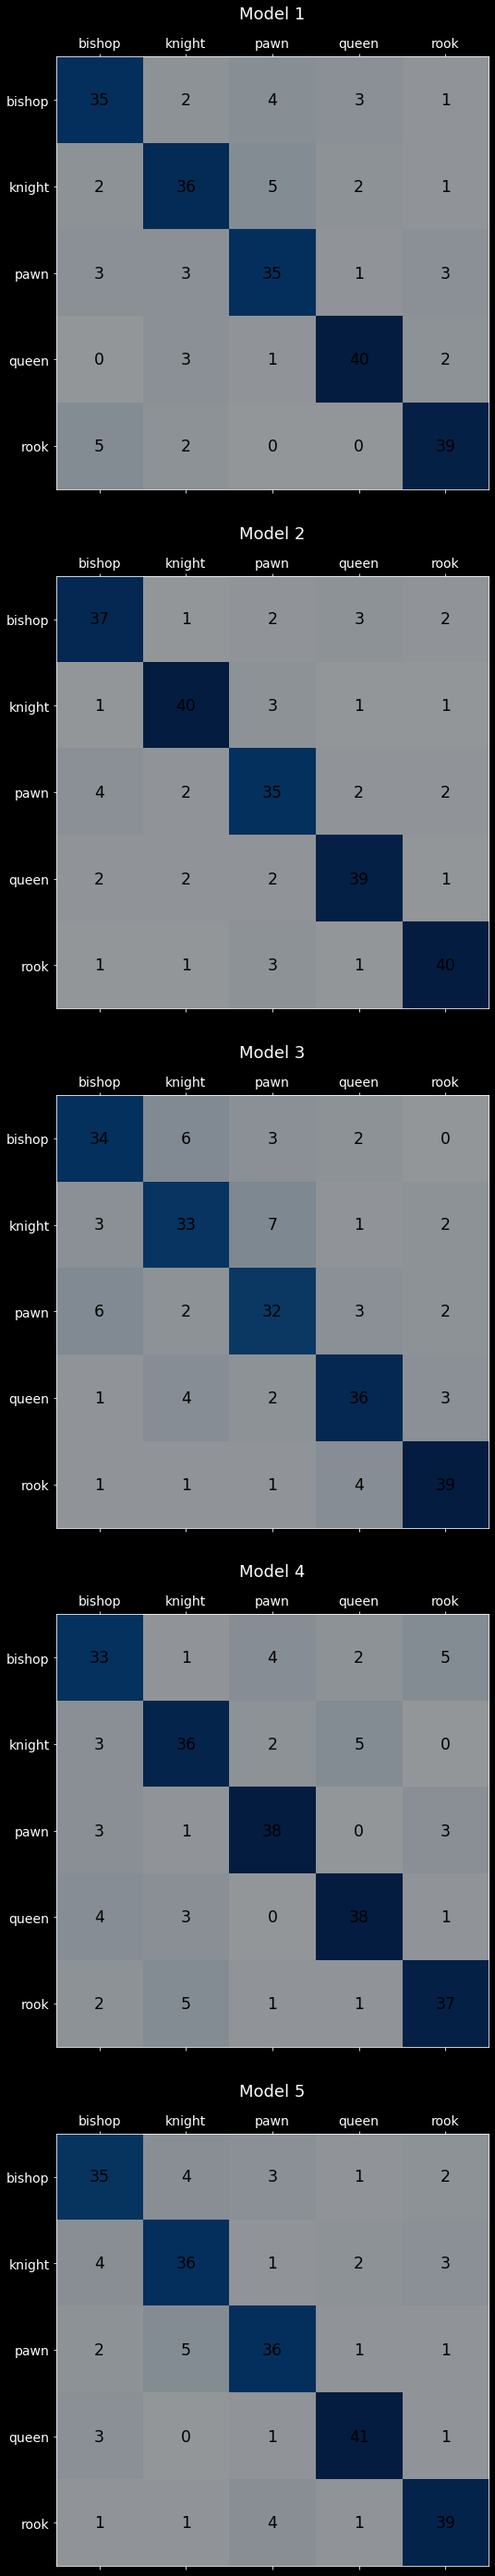

In [14]:
# The confusion matrix
from neural_network.metrics import confusion_matrix
cmats = [confusion_matrix(y_test, prediction) for prediction in predictions]

fig, axs = plt.subplots(nrows=n_splits, ncols=1, figsize=(20, 50))

for i, (ax, cmat) in enumerate(zip(axs.flatten(), cmats), start=1):
    ax.matshow(cmat, cmap='Blues', alpha=0.6)
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(map(str, names), fontsize=14)
    ax.set_yticks(np.arange(len(names)))
    ax.set_yticklabels(map(str, names), fontsize=14)
    ax.set_title(f'Model {i}', fontsize=18)

    for i in range(cmat.shape[0]):
        for j in range(cmat.shape[1]):
            ax.text(x=j, y=i, s=cmat[i, j], va='center', 
                    ha='center', size='xx-large', color='black')
plt.show()

In [15]:
# Accuracy of the model
from neural_network.metrics import accuracy_score

acc = [accuracy_score(y_test, prediction) for prediction in predictions]
for n, acc_ in enumerate(acc, start=1):
    print(f'Model {n} | Testing Accuracy: {np.around(acc_ * 100, 3)}%')

Model 1 | Testing Accuracy: 81.14%
Model 2 | Testing Accuracy: 83.772%
Model 3 | Testing Accuracy: 76.316%
Model 4 | Testing Accuracy: 79.825%
Model 5 | Testing Accuracy: 82.018%


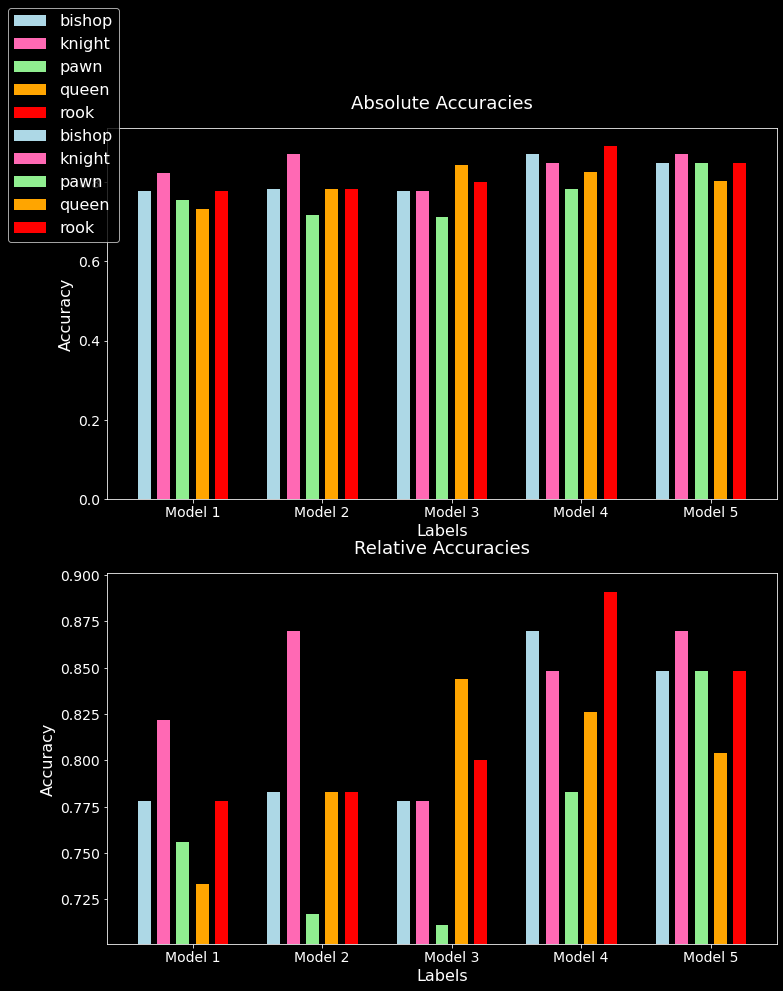

In [16]:
# Accuracy by label
from neural_network.metrics import accuracy_by_label
acc_by_label = [accuracy_by_label(y_test, prediction) for prediction in predictions]
acc_by_label = [np.around(acc_, 3) for acc_ in acc_by_label]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))
for i, acc_ in enumerate(acc_by_label):
    ax1.bar(
        (np.arange(len(acc_)) * 10) + ((i - 2.5) * 1.5),
        acc_,
        width=1,
        color=colors[i],
        label=names[i]
    )
    ax2.bar(
        (np.arange(len(acc_)) * 10) + ((i - 2.5) * 1.5),
        acc_,
        width=1,
        color=colors[i],
        label=names[i]
    )

ax1.set_xticks((np.arange(len(acc_)) * 10))
ax1.set_xticklabels([f'Model {i+1}' for i in range(len(models))])
ax1.set_xlabel('Labels', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=16)
ax1.set_title('Absolute Accuracies', fontsize=18)
ax1.tick_params(axis='both', labelsize=14)
    
ax2.set_xticks((np.arange(len(acc_)) * 10))
ax2.set_xticklabels([f'Model {i+1}' for i in range(len(models))])
ax2.set_xlabel('Labels', fontsize=16)
ax2.set_ylabel('Accuracy', fontsize=16)
ax2.set(ylim=[np.min(acc_by_label) - 0.01, np.max(acc_by_label) + 0.01])
ax2.set_title('Relative Accuracies', fontsize=18)
ax2.tick_params(axis='both', labelsize=14)

# ax1.legend(loc='upper left')
# ax2.legend(loc='upper left')

fig.legend(loc='upper left')

plt.show()